# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

All lables:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


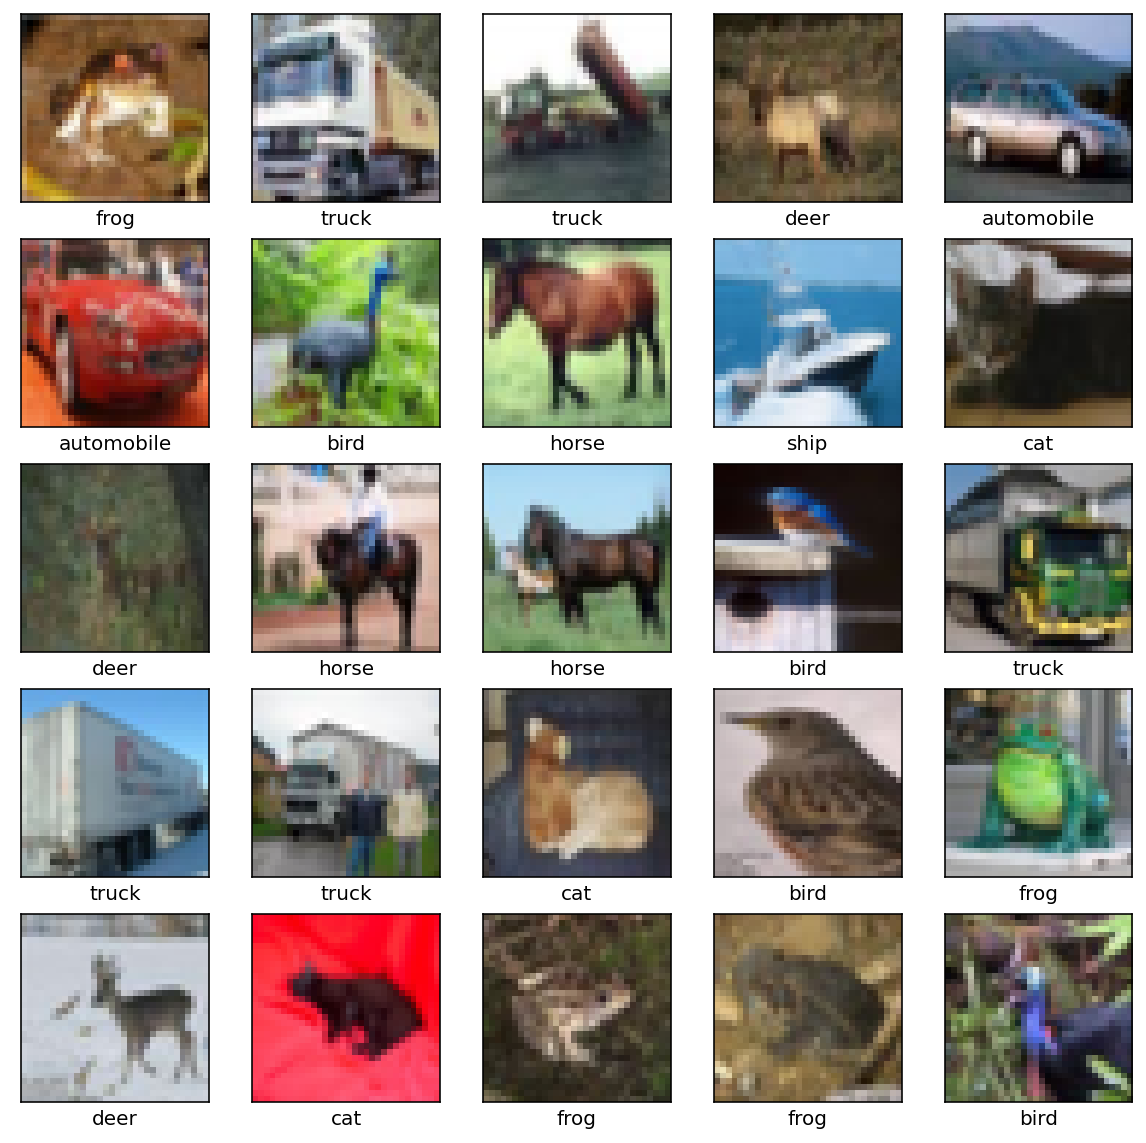

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x / 255.0

### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [4]:
from operator import length_hint
from unittest import result

label_mapping = {}

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    index = -1
    current_changes = {}
    for value in x:
        label = value
        if value not in label_mapping:
            index += 1
            label_mapping[value] = index
            current_changes[value] = index
    
    if (len(current_changes) > 0):
        print("Added: {}".format(current_changes))
    
    coding_size = len(label_mapping)
    data_size = len(x)
    result = np.zeros((data_size, coding_size))
    for i in range(0, data_size):
        current_encode = np.zeros(coding_size)
        current_encode[label_mapping[x[i]]] = 1
        result[i] = current_encode
    
    return result

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
# Don't use one_hot_encode
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, None)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [1]:
from statistics import mode
import tensorflow as tf

def conv_net(input_shape, keep_prob, output_num):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    model = tf.keras.models.Sequential(name='logits')
    model.add(tf.keras.Input(shape=input_shape))


    # Function Definition from Above:
    conv_count = 3
    conv_num_outputs = 3
    conv_ksize = (4, 4)
    conv_strides = (1, 1)
    pool_ksize = (4, 4)
    pool_strides = (1, 1)

    for i in range(0, conv_count):
        conv_num_outputs += 2

        model.add(tf.keras.layers.Conv2D(
            conv_num_outputs, 
            conv_ksize, 
            strides=conv_strides, 
            activation='relu'))
        
        model.add(tf.keras.layers.MaxPooling2D(
            pool_ksize, 
            strides=pool_strides))


    # Function Definition from Above:
    model.add(tf.keras.layers.Flatten())
    

    # Function Definition from Above:
    dense_count = 2
    dense_output = 128
    for i in range(0, dense_count):
        model.add(tf.keras.layers.Dense(dense_output, activation="relu"))
    
    
    # Function Definition from Above:
    model.add(tf.keras.layers.Dropout(keep_prob))
    model.add(tf.keras.layers.Dense(output_num, activation="relu"))
    
    return model

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
# tf.reset_default_graph()

# Inputs
image_input_shape = (32, 32, 3)
label_input_num = 10
keep_prob = 0.5

# Model
logits = conv_net(image_input_shape, keep_prob, label_input_num)

# Loss and Optimizer
cost = loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
logits.compile(optimizer='adam', loss=cost, metrics=['accuracy'])
logits.summary()

2022-07-18 20:17:05.592874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 20:17:05.592959: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "logits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 5)         245       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 7)         567       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 7)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 9)         1017      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 9)        0    

2022-07-18 20:17:09.069581: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-18 20:17:09.069642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Galaxy): /proc/driver/nvidia/version does not exist


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [8]:
import pickle
import helper
import numpy as np

print('Checking the Training on a Single Batch...')

epochs = 1
batch_size = None

# Loading training data
n_batches = 5
batch_features, batch_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

for batch_i in range(1, n_batches + 1):
    print('Loading CIFAR-10 Batch: ', batch_i)
    for b_features, b_labels in helper.load_preprocess_training_batch(1, batch_size):
        batch_features = np.append(batch_features, b_features, axis=0)
        batch_labels = np.append(batch_labels, b_labels, axis=0)

print("batch_features.shape:{}, batch_labels.shape:{}".format(batch_features.shape, batch_labels.shape))

logits.fit(batch_features, batch_labels, validation_split=0.2, epochs=epochs)

Checking the Training on a Single Batch...
Loading CIFAR-10 Batch:  1
Loading CIFAR-10 Batch:  2
Loading CIFAR-10 Batch:  3
Loading CIFAR-10 Batch:  4
Loading CIFAR-10 Batch:  5
batch_features.shape:(50000, 32, 32, 3), batch_labels.shape:(50000,)


2022-07-18 20:33:18.078646: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 [==============================] - 47s 38ms/step - loss: 1.0876 - accuracy: 0.6108 - val_loss: 0.9151 - val_accuracy: 0.6686


In [9]:
# Save Model
logits.save_weights('./model.md')

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

In [10]:
test_images, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))

test_loss, test_acc = logits.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 5s - loss: 1.7547 - accuracy: 0.4585 - 5s/epoch - 16ms/step

Test accuracy: 0.4584999978542328


## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.